# Model removal from dv/v for comparison

We compair the dv/v time history to the cumulative strain to investigate the relationship between them.
We removed the models associated with precipitation and temperature, wherease we keep both log heal model and linear trend to avoid the bias of model removal.

2023.5.4 Kurama Okubo

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import h5py
import glob
import matplotlib as mpl
import pickle
import matplotlib.dates as dates

import shutil
from tqdm import tqdm

from MCMC_func import * # use computing the model dv/v

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 0
plt.rcParams["xtick.minor.width"] = 0
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True


# Workflow
1. Preprocess the dv/v trace. We remove the model associated with the precipitation, temperature with maximum likelihood paramters from the data.
2. Remove the offset around 2009/01 from the dv/v time history.
3. Store t, dvvmethod, dvv, cumulative dilation and max shear into the dataframe.
4. Make scatter plot and fitting with linear regression to evaluate the sensitivity.

In [2]:
output_imgdir = "../figure/straindvv_comparison"
output_datadir = "../data"

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)
    
if not os.path.exists(output_datadir):
    os.makedirs(output_datadir)

## Read dv/v data

In [3]:
root = "../../ModelFit/processed_data/"
h5_stats_list = [root+"02dvvanderr_formodelfit_chanweighted_dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_stretching.csv_0.9-1.2.h5",
                    root+"02dvvanderr_formodelfit_chanweighted_dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_mwcs.csv_0.9-1.2.h5"]

starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

refstarttime = datetime.datetime(2010, 1, 1)
refendtime = datetime.datetime(2022, 6, 1)

vlines = [datetime.datetime(2003, 12, 12), datetime.datetime(2004, 9, 28)] 

h5_id = 1 # 0:stretching 1: mwcs; we process both in the later cells.
modelcase = "wlin" # use wlin model

In [4]:
casename = os.path.basename(h5_stats_list[h5_id].split('.h5')[0])
freqband = h5_stats_list[h5_id].split('.h5')[0].split('_')[-1]
dvvmethod = casename.split('.csv')[0].split('_')[-1]


In [5]:
fi = h5py.File(h5_stats_list[h5_id], "r")

In [6]:
# extract auto-correlation pair
stationlist_ac = []
for st in fi["dvv"].keys():
    sta1, sta2 = st.split("-")
    if sta1==sta2:
        stationlist_ac.append(st)    

In [7]:
stationpair = stationlist_ac[0]

In [8]:
uniform_tvec_unix = np.array(fi["uniform_tvec"])
uniform_tvec = np.array([datetime.datetime.fromtimestamp(x) for x in uniform_tvec_unix])
dvv_data = np.array(fi["dvv/{}/dvv".format(stationpair)])
err_data = np.array(fi["dvv/{}/err".format(stationpair)])


In [9]:
# read model parameters
finame = f"../../ModelFit/modelparam_data/MCMC_modelparam_{stationpair}_{dvvmethod}_{freqband}Hz_{modelcase}.pickle"
with open(finame, "rb") as f:
    modelparam = pickle.load(f)

    
# read best fit model paramters
df_param = pd.read_csv(f"../../ModelFit/data_stats/MCMC_modelparam_all_{dvvmethod}_{freqband}_wlin.csv", index_col=0)
df_pair = df_param.loc[stationpair]
theta_series = df_pair[3:16]

print(modelparam["ndim"], theta_series)


10 a0              -0.024368
p1              -0.003066
a_{precip}        0.03888
p2               0.000499
t_{shiftdays}    2.760955
S1               0.008467
log10tmin1          4.903
log10tmax1       8.706226
S2               0.023473
log10tmin2          6.993
log10tmax2       8.376221
b_{lin}          0.000005
logf            -3.699385
Name: BP.CCRB-BP.CCRB, dtype: object


In [10]:
# compute dv/v components
dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF, lintrend = model_wlin(theta_series.values, all=True, **modelparam)

In [11]:
# remove the model
dvvmodel_IsOffsetRemoval = True
tSS = datetime.datetime(2003, 12, 22) # time for San Simeon

dvv_removalcomp = theta_series["a0"] + dvvgwl + dvvtemp # + dvvhealSS + dvvhealPF # components to be removed

if dvvmodel_IsOffsetRemoval:
    offset_ind = np.where(np.array(uniform_tvec) < tSS)
    offset_data = np.nanmean(dvv_data[offset_ind])
    dvv_data_offsetremoved  = dvv_data - offset_data
    dvv_removalcomp = dvv_removalcomp - offset_data

else:
    dvv_data_offsetremoved = dvv_data
    
dvv_data_modelremoved = dvv_data_offsetremoved - dvv_removalcomp

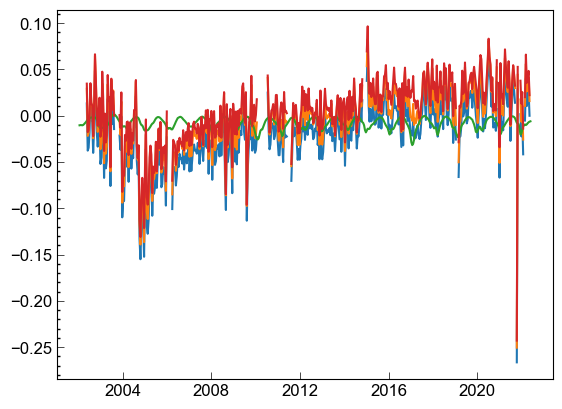

In [12]:
plt.plot(uniform_tvec, dvv_data)
plt.plot(uniform_tvec, dvv_data_offsetremoved)
plt.plot(uniform_tvec, dvv_removalcomp)
plt.plot(uniform_tvec, dvv_data_modelremoved)

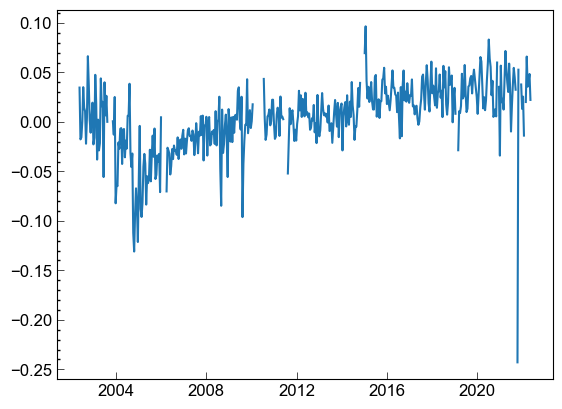

In [13]:
plt.plot(uniform_tvec, dvv_data_modelremoved)

In [14]:
# taking the offset around 2009 to be compared with strain
strainoffset_st = datetime.datetime(2008, 1, 1)
strainoffset_et = datetime.datetime(2010, 1, 1)

offset_ind_strain = np.where((strainoffset_st < uniform_tvec) & (uniform_tvec < strainoffset_et))

# remove the offset using the period between strainoffset_st and strainoffset_et
dvv_data_offsetremoved_offsetstrainremoved = dvv_data_offsetremoved-np.nanmean(dvv_data_offsetremoved[offset_ind_strain])

dvv_removalcomp_offsetstrainremoved = dvv_removalcomp-np.nanmean(dvv_removalcomp[offset_ind_strain])

dvv_data_modelremoved_offsetstrainremoved = dvv_data_modelremoved-np.nanmean(dvv_data_modelremoved[offset_ind_strain])

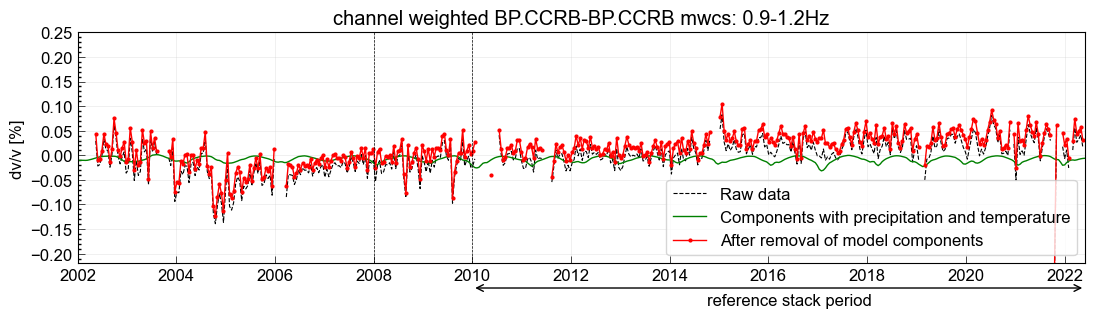

In [15]:
# plot schematic
fig, ax = plt.subplots(1, 1, figsize=(13,3))

ax.plot(uniform_tvec, dvv_data_offsetremoved, "k--", lw=0.8, label="Raw data")
ax.plot(uniform_tvec, dvv_removalcomp, "g-", lw=1, label="Components with precipitation and temperature")
ax.plot(uniform_tvec, dvv_data_modelremoved_offsetstrainremoved, "ro-", lw=1, ms=2, label="After removal of model components")

xfmt = dates.DateFormatter('%Y')

ax.set_ylim(-0.22, 0.25)
ax.set_yticks(np.linspace(-0.20, 0.25, 10))
ax.set_ylabel("dv/v [%]")
ax.set_xlim(starttime, endtime)
ax.grid(True, axis="both", lw=0.5, c=[0.8, 0.8, 0.8], alpha=0.4, zorder=-20)

# annotate reference period
refy = -0.27
ax.annotate('', xy=(refstarttime, refy), xytext=(refendtime, refy), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
ax.text(datetime.datetime(2016,6,1), -0.28, "reference stack period", ha="center", va='top')
# axs[1].plot([refstarttime, refendtime], [-0.3, -0.3], clip_on=False,)

# annotate the time for comparison
ax.axvline(strainoffset_st, lw=0.5, ls="--", c="k")
ax.axvline(strainoffset_et, lw=0.5, ls="--", c="k")

ax.set_title(f"channel weighted {stationpair} {dvvmethod}: {freqband}Hz")
ax.legend(loc=4)

foname = (output_imgdir+"/ex_dvvstraincomparison_removelmodel_{}_{}_{}_{}.png".format(stationpair, dvvmethod, freqband, modelparam["modelcase"]))
plt.savefig(foname, dpi=150, bbox_inches='tight')

In [16]:
# output data
dfdict = dict(tvec = uniform_tvec, stationpair=stationpair, dvvmethod=dvvmethod, dvv_data = dvv_data, err_data = err_data, dvv_data_modelremoved = dvv_data_modelremoved_offsetstrainremoved)
df_dvvforstrain = pd.DataFrame.from_dict(dfdict).set_index("tvec")
df_dvvforstrain

,stationpair,dvvmethod,dvv_data,err_data,dvv_data_modelremoved
tvec,,,,,
2002-01-16,BP.CCRB-BP.CCRB,mwcs,NaN,NaN,NaN
2002-01-31,BP.CCRB-BP.CCRB,mwcs,NaN,NaN,NaN
2002-02-15,BP.CCRB-BP.CCRB,mwcs,NaN,NaN,NaN
2002-03-02,BP.CCRB-BP.CCRB,mwcs,NaN,NaN,NaN
2002-03-17,BP.CCRB-BP.CCRB,mwcs,NaN,NaN,NaN
...,...,...,...,...,...
2022-04-01,BP.CCRB-BP.CCRB,mwcs,0.010472,0.000002,0.044118
2022-04-16,BP.CCRB-BP.CCRB,mwcs,0.017059,0.000004,0.049469
2022-05-01,BP.CCRB-BP.CCRB,mwcs,0.025492,0.000004,0.056914


# Compute for all stations

In [17]:
df_dvvforstrain.columns

Index(['stationpair', 'dvvmethod', 'dvv_data', 'err_data',
       'dvv_data_modelremoved'],
      dtype='object')

In [18]:
df_dvvforstrain_all = pd.DataFrame(index=df_dvvforstrain.index, columns=
                                   ['stationpair', 'dvvmethod', 'dvv_data', 'err_data','dvv_data_modelremoved'])

0
processing BP.CCRB-BP.CCRB
processing BP.EADB-BP.EADB
processing BP.GHIB-BP.GHIB
processing BP.JCSB-BP.JCSB
processing BP.LCCB-BP.LCCB
processing BP.MMNB-BP.MMNB
processing BP.SCYB-BP.SCYB
processing BP.SMNB-BP.SMNB
processing BP.VCAB-BP.VCAB
1
processing BP.CCRB-BP.CCRB
processing BP.EADB-BP.EADB
processing BP.GHIB-BP.GHIB
processing BP.JCSB-BP.JCSB
processing BP.LCCB-BP.LCCB
processing BP.MMNB-BP.MMNB
processing BP.SCYB-BP.SCYB
processing BP.SMNB-BP.SMNB
processing BP.VARB-BP.VARB
processing BP.VCAB-BP.VCAB


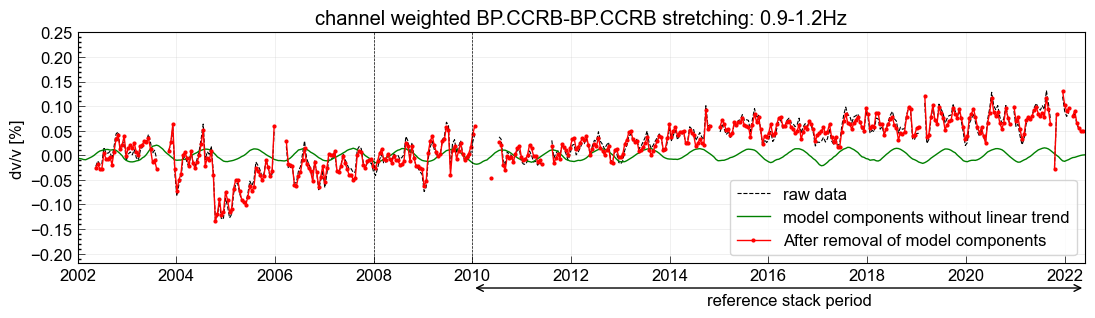

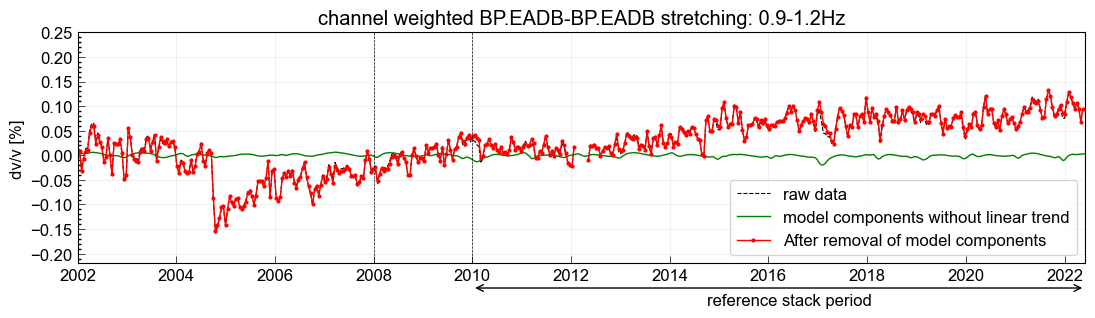

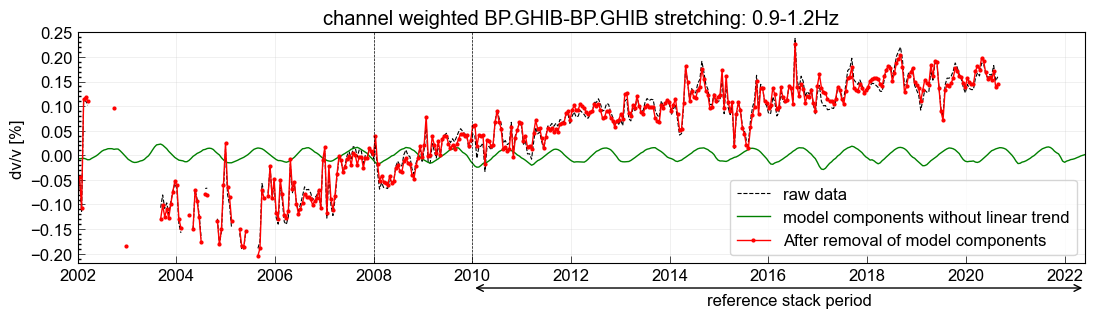

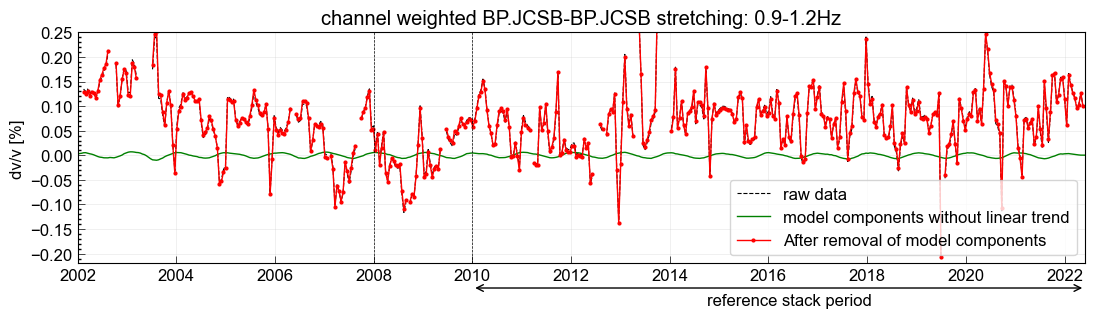

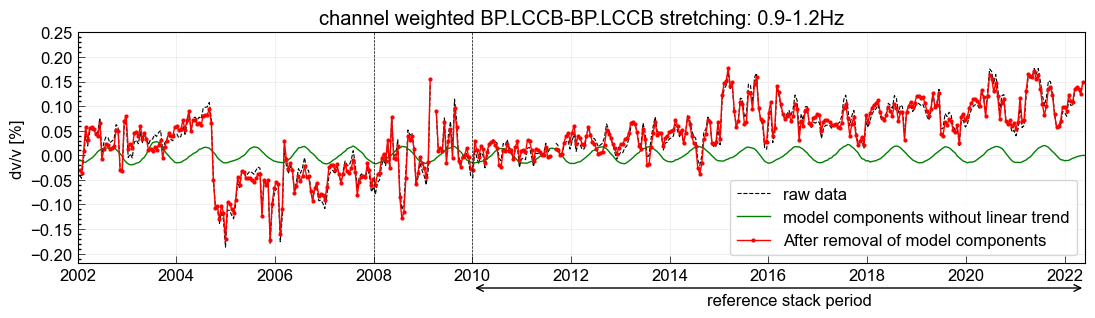

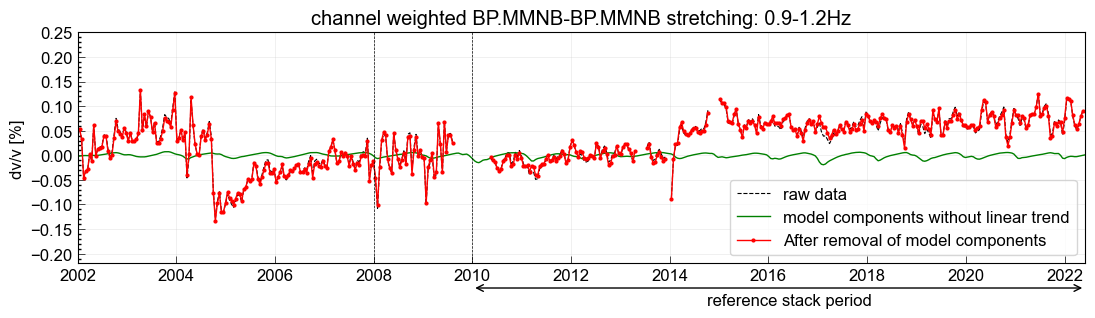

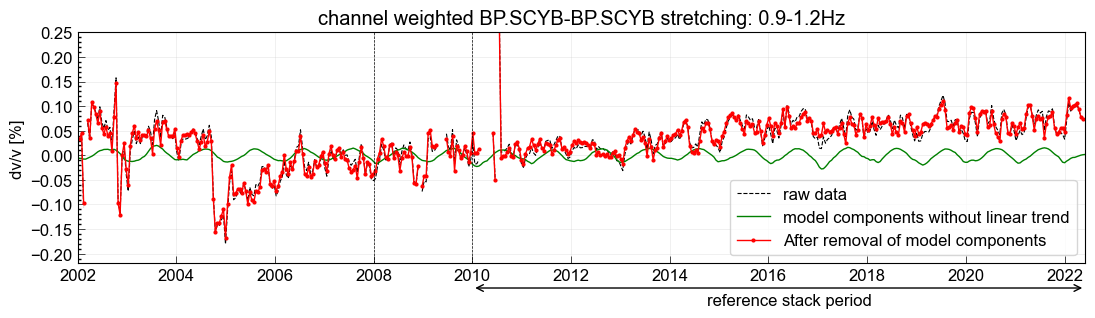

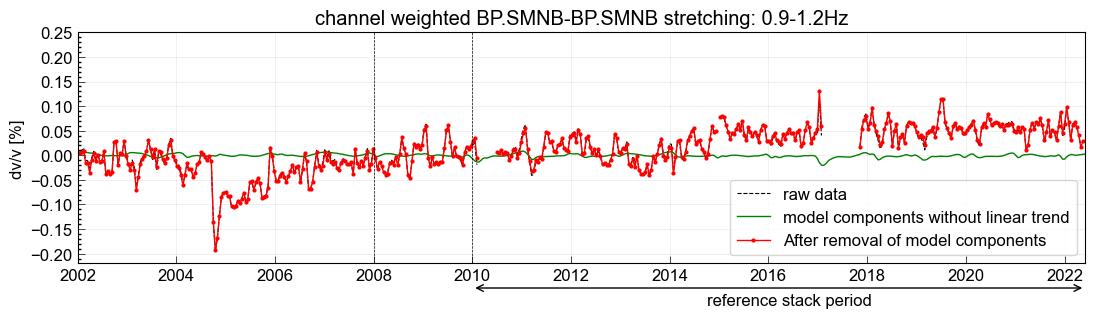

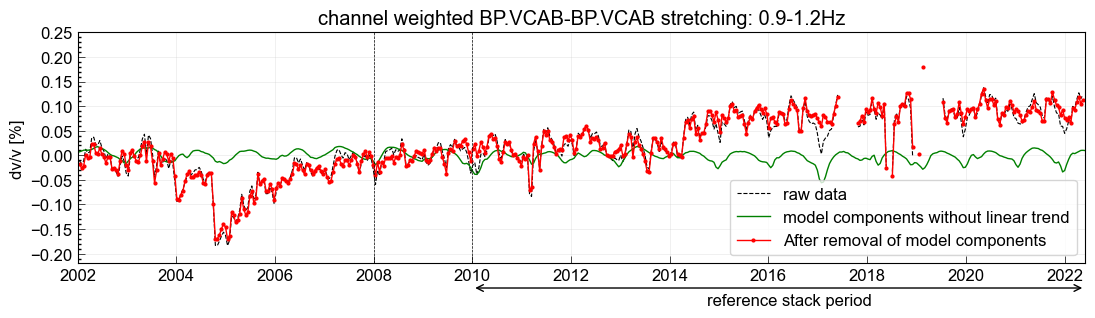

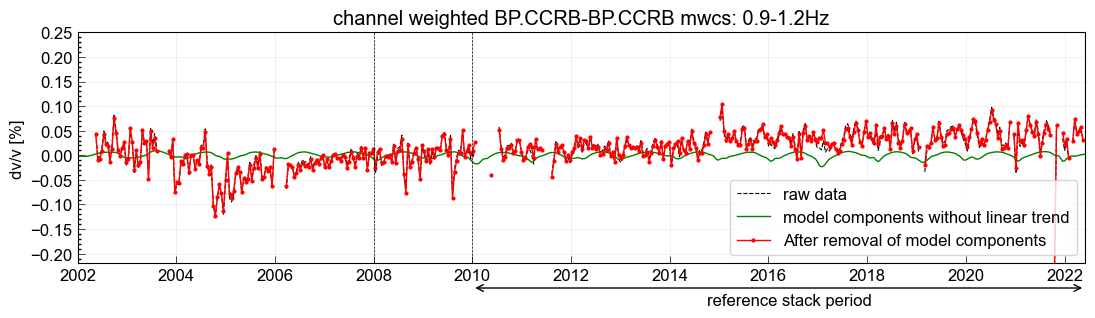

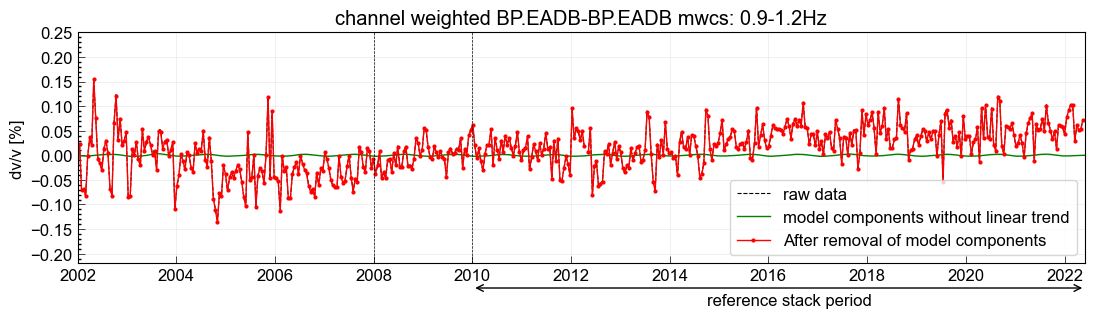

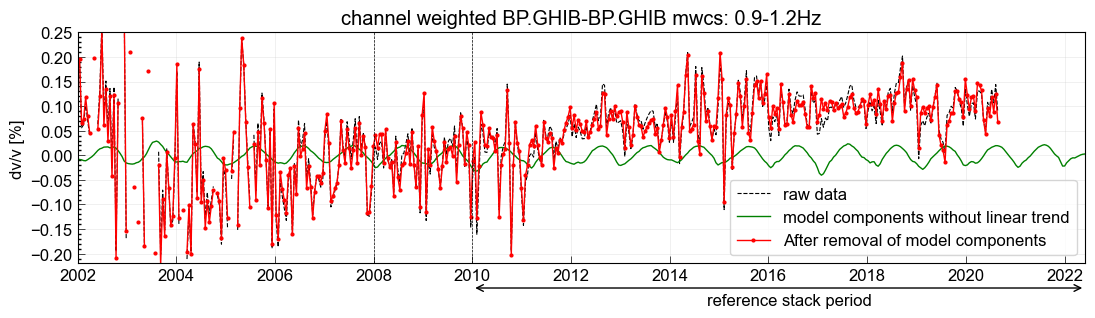

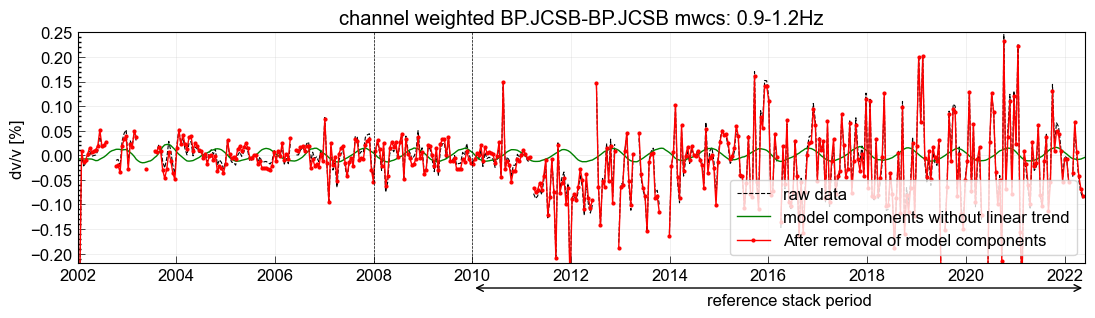

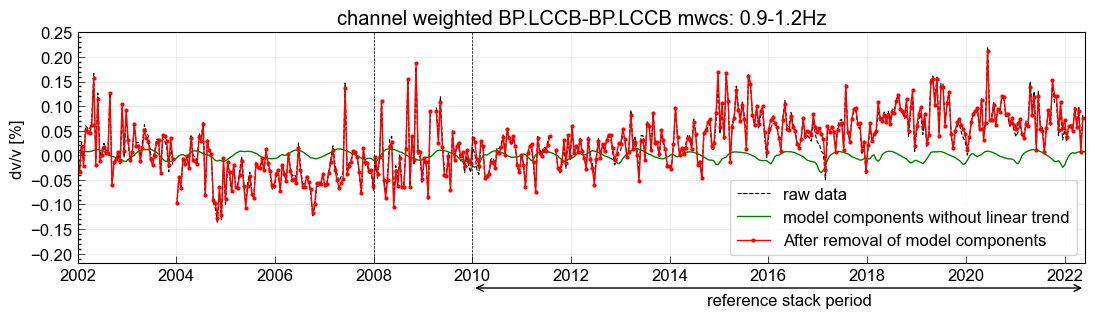

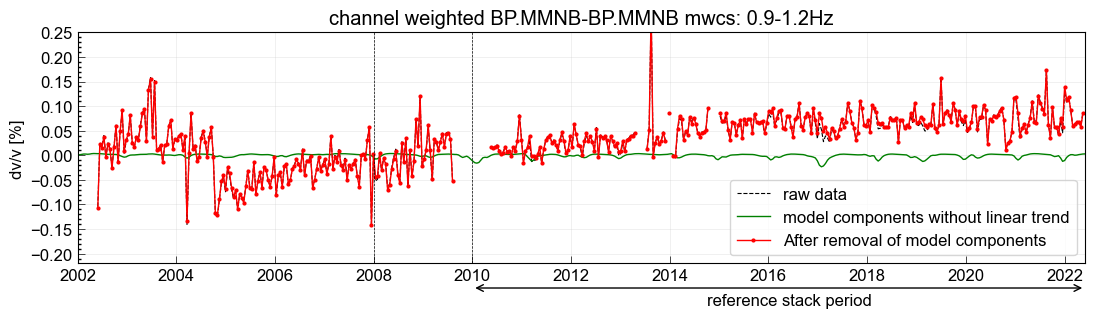

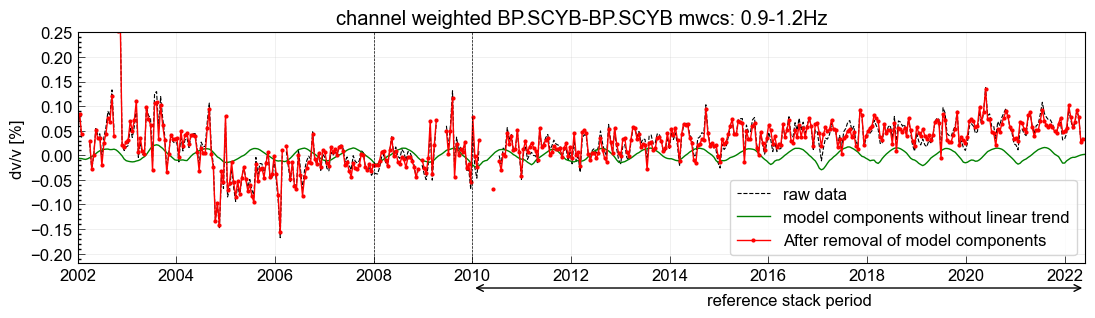

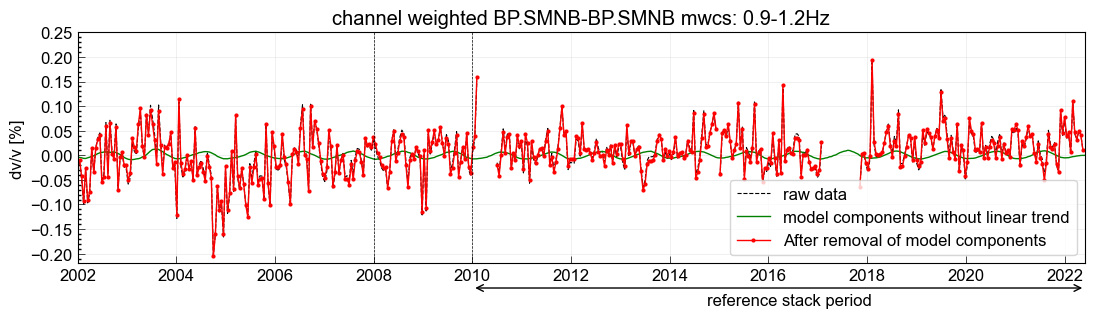

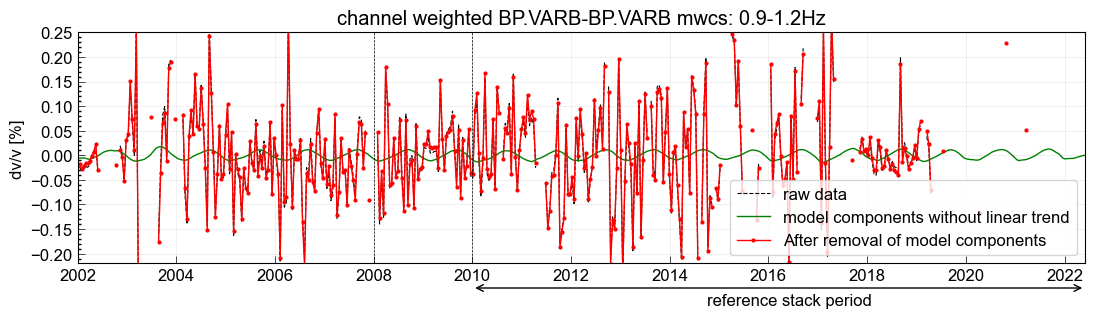

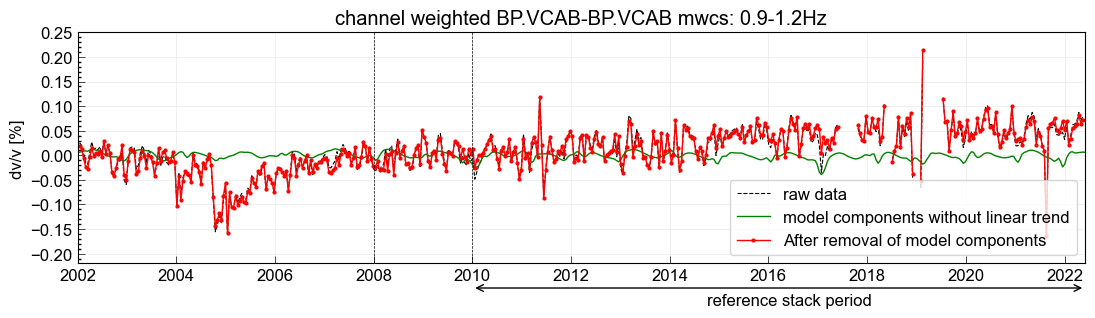

In [19]:
# dvvmodel_IsOffsetRemoval = True # deprecated as we remove offset around the GNSS start period
tSS = datetime.datetime(2003, 12, 22) # time for San Simeon
strainoffset_st = datetime.datetime(2008, 1, 1)
strainoffset_et = datetime.datetime(2010, 1, 1)

df_dvvforstrain_all = pd.DataFrame(columns=df_dvvforstrain.columns)

for h5_id in [0, 1]: 
    
    fi = h5py.File(h5_stats_list[h5_id], "r")
    print(h5_id)
    
    uniform_tvec_unix = np.array(fi["uniform_tvec"])
    uniform_tvec = np.array([datetime.datetime.fromtimestamp(x) for x in uniform_tvec_unix])

    # extract auto-correlation pair: we need to renew stationlist as the stretching and mwcs have different set of pairs 
    stationlist_ac = []
    for st in fi["dvv"].keys():
        sta1, sta2 = st.split("-")
        if sta1==sta2:
            stationlist_ac.append(st)    

    casename = os.path.basename(h5_stats_list[h5_id].split('.h5')[0])
    freqband = h5_stats_list[h5_id].split('.h5')[0].split('_')[-1]
    dvvmethod = casename.split('.csv')[0].split('_')[-1]
    
    for stationpair in stationlist_ac:
        print(f"processing {stationpair}")
        dvv_data = np.array(fi["dvv/{}/dvv".format(stationpair)])
        err_data = np.array(fi["dvv/{}/err".format(stationpair)])


        # read model parameters
        finame = f"../../ModelFit/modelparam_data/MCMC_modelparam_{stationpair}_{dvvmethod}_{freqband}Hz_{modelcase}.pickle"
        with open(finame, "rb") as f:
            modelparam = pickle.load(f)

        # read best fit model paramters
        df_param = pd.read_csv(f"../../ModelFit/data_stats/MCMC_modelparam_all_{dvvmethod}_{freqband}_wlin.csv", index_col=0)
        df_pair = df_param.loc[stationpair]
        theta_series = df_pair[3:16]

        # compute dv/v components
        dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF, lintrend = model_wlin(theta_series.values, all=True, **modelparam)

        # remove the model
        dvv_removalcomp = theta_series["a0"] + dvvgwl + dvvtemp # + dvvhealSS + dvvhealPF # components to be removed; except both healing and linear term 

#         if dvvmodel_IsOffsetRemoval:
        offset_ind = np.where(np.array(uniform_tvec) < tSS)
        offset_data = np.nanmean(dvv_data[offset_ind])
        dvv_data_offsetremoved  = dvv_data - offset_data
        dvv_removalcomp = dvv_removalcomp - offset_data

#         else:
#             dvv_data_offsetremoved = dvv_data

        dvv_data_modelremoved = dvv_data_offsetremoved - dvv_removalcomp # dvv without precipitation and temperature


        # taking the offset around 2009 to be compared with strain
        offset_ind_strain = np.where((strainoffset_st < uniform_tvec) & (uniform_tvec < strainoffset_et))
       
        # remove the offset using the period between strainoffset_st and strainoffset_et
        dvv_data_offsetremoved_offsetstrainremoved = dvv_data_offsetremoved-np.nanmean(dvv_data_offsetremoved[offset_ind_strain])
        dvv_removalcomp_offsetstrainremoved = dvv_removalcomp-np.nanmean(dvv_removalcomp[offset_ind_strain])
        dvv_data_modelremoved_offsetstrainremoved = dvv_data_modelremoved-np.nanmean(dvv_data_modelremoved[offset_ind_strain])

        # plot schematic
        fig, ax = plt.subplots(1, 1, figsize=(13,3))

        ax.plot(uniform_tvec, dvv_data_offsetremoved_offsetstrainremoved, "k--", lw=0.8, label="raw data")
        ax.plot(uniform_tvec, dvv_removalcomp_offsetstrainremoved, "g-", lw=1, label="model components without linear trend")
        ax.plot(uniform_tvec, dvv_data_modelremoved_offsetstrainremoved, "ro-", lw=1, ms=2, label="After removal of model components")

        xfmt = dates.DateFormatter('%Y')

        ax.set_ylim(-0.22, 0.25)
        ax.set_yticks(np.linspace(-0.20, 0.25, 10))
        ax.set_ylabel("dv/v [%]")
        ax.set_xlim(starttime, endtime)
        ax.grid(True, axis="both", lw=0.5, c=[0.8, 0.8, 0.8], alpha=0.4, zorder=-20)

        # annotate reference period
        refy = -0.27
        ax.annotate('', xy=(refstarttime, refy), xytext=(refendtime, refy), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
        ax.text(datetime.datetime(2016,6,1), -0.28, "reference stack period", ha="center", va='top')
        # axs[1].plot([refstarttime, refendtime], [-0.3, -0.3], clip_on=False,)

        # annotate the time for the offset around 2009
        ax.axvline(strainoffset_st, lw=0.5, ls="--", c="k")
        ax.axvline(strainoffset_et, lw=0.5, ls="--", c="k")

        ax.set_title(f"channel weighted {stationpair} {dvvmethod}: {freqband}Hz")
        ax.legend(loc=4)

        foname = (output_imgdir+"/dvvstraincomparison_removelmodel_{}_{}_{}_{}.png".format(stationpair, dvvmethod, freqband, modelparam["modelcase"]))
        plt.savefig(foname, dpi=150, bbox_inches='tight')

        # output data
        dfdict = dict(tvec = uniform_tvec, stationpair=stationpair, dvvmethod=dvvmethod, dvv_data = dvv_data, err_data = err_data, dvv_data_modelremoved = dvv_data_modelremoved_offsetstrainremoved)
        df_dvvforstrain = pd.DataFrame.from_dict(dfdict).set_index("tvec")

        df_dvvforstrain_all = pd.concat([df_dvvforstrain_all, df_dvvforstrain])
    #     print(modelparam["ndim"], theta_series)

    del fi
    

In [20]:
# save csv for the comparison

df_dvvforstrain_all.to_csv(output_datadir+f"/dvvforstraincomparison_{modelcase}.csv")

In [21]:
df_dvvforstrain_all

,stationpair,dvvmethod,dvv_data,err_data,dvv_data_modelremoved
2002-01-16,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
2002-01-31,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
2002-02-15,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
2002-03-02,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
2002-03-17,BP.CCRB-BP.CCRB,stretching,NaN,NaN,NaN
...,...,...,...,...,...
2022-04-01,BP.VCAB-BP.VCAB,mwcs,0.036432,0.000001,0.064128
2022-04-16,BP.VCAB-BP.VCAB,mwcs,0.054801,0.000002,0.081709
2022-05-01,BP.VCAB-BP.VCAB,mwcs,0.037922,0.000002,0.064358
2022-05-16,BP.VCAB-BP.VCAB,mwcs,0.046758,0.000002,0.072758
